In [1]:
##
## Udacity PRORJECT - Behaviour Cloning 
##

import csv 
import cv2
import numpy as np
from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, Input, Lambda, SpatialDropout2D,MaxPooling2D
from keras.layers import Cropping2D
import sklearn
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from keras.regularizers import l2



Using TensorFlow backend.


In [2]:
##
##  Read the data from driving_log generated using the simulator in training mode
## 
lines = []
with open("training_data/driving_log.csv") as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)
        
#
#  Reading the img_paths (center,left,right img path and taking sterring angle correction for left, right into account)
#
img_paths = []
measurements =[]
for line in lines:
    ## Read Center,left,right images (More the data better the training)
    steering_center = float(line[3])

    # create adjusted steering measurements for the side camera images
    correction = 0.20 # Tuned it after multiple iteration {Ideally it can be calculated mathematically}
    steering_left = steering_center + correction
    steering_right = steering_center - correction

    # read in images from center, left and right cameras
    # directory = "..." # fill in the path to your training IMG directory
    img_center = line[0]
    img_left = line[1]
    img_right = line[2]

    # add images 
    img_paths.append(img_center)
    img_paths.append(img_left)
    img_paths.append(img_right)
    
    # add measuremnts 
    measurements.append(steering_center)
    measurements.append(steering_left)
    measurements.append(steering_right)
    
img_paths = np.array(img_paths)
measurements = np.array(measurements)

print('Img_path and measurements :', img_paths.shape, measurements.shape)

Img_path and measurements : (9021,) (9021,)


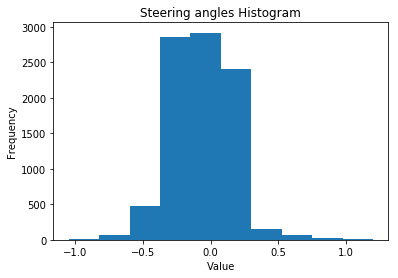

Bias towards straight path


In [3]:
# Plot distribution of samples steering initial angles after prefiltering central angle samples
plt.hist(measurements)
plt.title("Steering angles Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.gcf()
plt.show()

print ('Bias towards straight path')

In [4]:
# Calculate the index to filter the data 
# It will eliminate bias towards 0 stearing.

threshold = 0.01  ## Stearing threshold
keepPercent = 0.40 ## Keep 40% data
remove_index = []

for i in range(len(measurements)):
    stearing = measurements[i]
    if(abs(stearing) > 0.85):
        remove_index.append(i)    
    if(abs(stearing < threshold)):        
        if np.random.random_sample() >keepPercent:
            remove_index.append(i)
            
           

print("How much data to remove ? -", len(remove_index))

How much data to remove ? - 3742


Img_path and measurements : (5284,) (5284,)


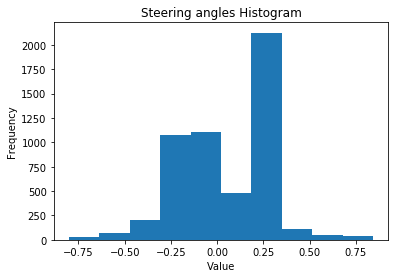

Filtered data


In [5]:
## Filter data 

img_paths = np.delete(img_paths, remove_index, axis=0)
measurements = np.delete(measurements, remove_index)


print('Img_path and measurements :', img_paths.shape, measurements.shape)

plt.hist(measurements)
plt.title("Steering angles Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.gcf()
plt.show() 

print('Filtered data')

In [6]:
##
##
from sklearn.model_selection import train_test_split
samples = list(zip(img_paths, measurements))
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

print('Number of train samples     : ', len(train_samples))
print('Number of validation samples: ', len(validation_samples))
 


Number of train samples     :  4227
Number of validation samples:  1057


Epoch 1/5
8454/8454 [==============================] - 241s - loss: 0.1001 - val_loss: 0.0479
Epoch 2/5
8454/8454 [==============================] - 238s - loss: 0.0352 - val_loss: 0.0277
Epoch 3/5
8454/8454 [==============================] - 238s - loss: 0.0250 - val_loss: 0.0233
Epoch 4/5
8454/8454 [==============================] - 238s - loss: 0.0213 - val_loss: 0.0204
Epoch 5/5
8454/8454 [==============================] - 238s - loss: 0.0192 - val_loss: 0.0192
dict_keys(['loss', 'val_loss'])
Loss
[0.100078692942195, 0.035228453687609636, 0.024965016141371692, 0.021285134110302754, 0.019152337331822755]
Validation Loss
[0.047859052102748469, 0.027650641769086177, 0.023258116663686487, 0.020392979048509698, 0.01922578022743918]


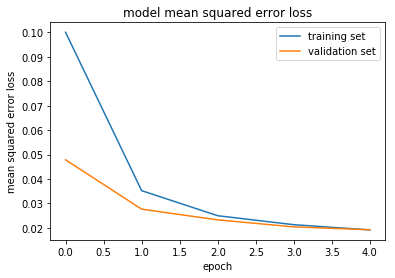

In [7]:
## Regression Network
from keras.models import Sequential
from keras.layers import Flatten, Dense


def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for path,measurement in batch_samples:

                #print(path)
                #print(measurement)
                
                image = cv2.imread(path)
                angle = float(measurement)
                
                images.append(image)
                angles.append(angle)
                
                # Augumented Image
                images.append(cv2.flip(image,1))
                angles.append(angle*-1.0)


            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)
            
               
            
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

model = Sequential()
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
# Crop the top 50% as it is mostly sky, and the bottom 20% as it is hood of the car 
model.add(Cropping2D(cropping=((50,20),(0,0))))

'''Google LeNet
model.add(Convolution2D(6,5,5,activation="relu"))
model.add(MaxPooling2D())
model.add(Convolution2D(6,5,5,activation="relu"))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(120))
model.add(Dense(84))
model.add(Dense(1))
'''

# NVDIA
reg = 1e-3
model.add(Convolution2D(24,5,5,subsample=(2,2),activation="relu"))
model.add(Convolution2D(36,5,5,subsample=(2,2),activation="relu"))
model.add(Convolution2D(48,5,5,subsample=(2,2),activation="relu"))
model.add(Convolution2D(64,3,3,activation="relu"))
model.add(Convolution2D(64,3,3,activation="relu"))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(100,activation="relu",W_regularizer=l2(reg)))
model.add(Dense(50,activation="relu",W_regularizer=l2(reg)))
model.add(Dense(10,activation="relu",W_regularizer=l2(reg)))
model.add(Dense(1))

model.compile(loss="mse", optimizer="adam")
history_object = model.fit_generator(train_generator, samples_per_epoch= len(train_samples)*2, validation_data=validation_generator, nb_val_samples=len(validation_samples)*2, nb_epoch=5, verbose =1)
model.save('model.h5')


### print the keys contained in the history object
print(history_object.history.keys())
print('Loss')
print(history_object.history['loss'])
print('Validation Loss')
print(history_object.history['val_loss'])

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()


# 